# GA Benchmark Analysis

**Author:** Mititean Cristian 

This notebook reads in the results from `../data/summary.csv` and detailed JSON files, and then:
1. Plots boxplots of final best-values for each configuration.
2. Plots convergence curves (mean ± std) if you saved per-generation histories.
3. Performs statistical tests (e.g. ANOVA, Tukey’s HSD) to compare configurations.
4. Summarizes results in tables and interprets them.

In [4]:
import os
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [ ]:
data_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir, 'data'))
# There should be exactly one “summary_*.csv” file; otherwise adjust name directly.
csv_files = [f for f in os.listdir(data_dir) if f.startswith('summary_') and f.endswith('.csv')]
assert len(csv_files) == 1, "Expected exactly one summary CSV in data/"

summary_path = os.path.join(data_dir, csv_files[0])
df_summary = pd.read_csv(summary_path)
df_summary

,config_id,func_name,encoding,crossover,pop_size,num_gens,mutation_rate,best_min,best_mean,best_std
0,rastrigin_binary_one_point,rastrigin,binary,one_point,50,200,0.01,2.421852e-06,0.456168,5.720230e-01
1,rastrigin_binary_two_point,rastrigin,binary,two_point,50,200,0.01,2.421852e-06,0.604790,7.081961e-01
2,rastrigin_real_arithmetic,rastrigin,real,arithmetic,50,200,0.10,9.530154e-11,0.596976,6.079301e-01
3,rastrigin_real_blx,rastrigin,real,blx,50,200,0.10,0.000000e+00,0.530645,6.666143e-01
4,six_hump_binary_one_point,six_hump,binary,one_point,50,200,0.01,-1.031628e+00,-1.025876,8.771406e-03
5,six_hump_binary_two_point,six_hump,binary,two_point,50,200,0.01,-1.031628e+00,-1.027959,7.030305e-03
6,six_hump_real_arithmetic,six_hump,real,arithmetic,50,200,0.10,-1.031628e+00,-1.031628,2.500991e-08
7,six_hump_real_blx,six_hump,real,blx,50,200,0.10,-1.031628e+00,-1.031628,3.872613e-09


C:\Users\Chris\AppData\Local\Temp\ipykernel_21780\2703541649.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


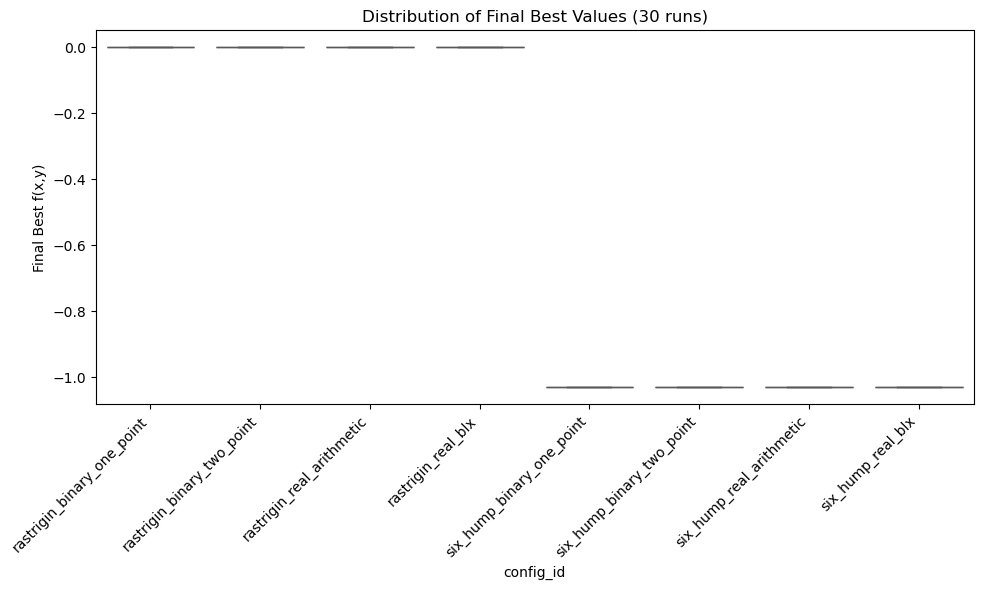

In [7]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    x='config_id',
    y='best_min',
    data=df_summary,
    palette='Set2'
)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Final Best f(x,y)')
plt.title('Distribution of Final Best Values (30 runs)')
plt.tight_layout()
plt.show()

In [9]:
# Example: Compare rastrigin_real_blx vs rastrigin_real_arithmetic
from itertools import combinations

# Load detailed JSON of best values for each config
def load_json_values(config_id):
    # find the JSON file(s) that start with config_id
    js_files = [f for f in os.listdir(data_dir) if f.startswith(config_id) and f.endswith('.json')]
    assert len(js_files) == 1
    with open(os.path.join(data_dir, js_files[0]), 'r') as fp:
        return np.array(json.load(fp))

cfg1 = 'rastrigin_real_arithmetic'
cfg2 = 'rastrigin_real_blx'

values1 = load_json_values(cfg1)
values2 = load_json_values(cfg2)

# Unpaired t-test
t_stat, p_val = stats.ttest_ind(values1, values2)
print(f"t-statistic = {t_stat:.3f}, p-value = {p_val:.4f}")

t-statistic = 0.396, p-value = 0.6936


In [10]:
rastrigin_cfgs = df_summary[df_summary['func_name'] == 'rastrigin']['config_id'].tolist()
all_vals = [load_json_values(cfg) for cfg in rastrigin_cfgs]

F_stat, p_anova = stats.f_oneway(*all_vals)
print(f"ANOVA F = {F_stat:.3f}, p = {p_anova:.4f}")

ANOVA F = 0.338, p = 0.7980


In [11]:
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Concatenate into a single DataFrame for Tukey’s test
records = []
for cfg in rastrigin_cfgs:
    vals = load_json_values(cfg)
    for v in vals:
        records.append({'config': cfg, 'value': v})
df_rast_vals = pd.DataFrame(records)

tukey = pairwise_tukeyhsd(endog=df_rast_vals['value'],
                          groups=df_rast_vals['config'],
                          alpha=0.05)
print(tukey)

                    Multiple Comparison of Means - Tukey HSD, FWER=0.05                    
          group1                     group2           meandiff p-adj   lower  upper  reject
-------------------------------------------------------------------------------------------
rastrigin_binary_one_point rastrigin_binary_two_point   0.1486 0.8136 -0.2901 0.5873  False
rastrigin_binary_one_point  rastrigin_real_arithmetic   0.1408 0.8369 -0.2979 0.5795  False
rastrigin_binary_one_point         rastrigin_real_blx   0.0745 0.9709 -0.3642 0.5132  False
rastrigin_binary_two_point  rastrigin_real_arithmetic  -0.0078    1.0 -0.4465 0.4309  False
rastrigin_binary_two_point         rastrigin_real_blx  -0.0741 0.9713 -0.5128 0.3645  False
 rastrigin_real_arithmetic         rastrigin_real_blx  -0.0663 0.9791  -0.505 0.3724  False
-------------------------------------------------------------------------------------------


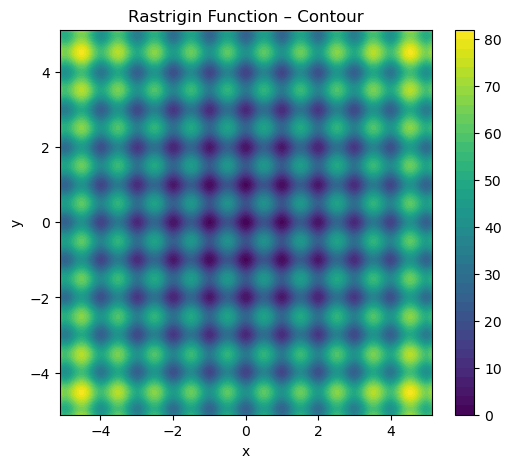

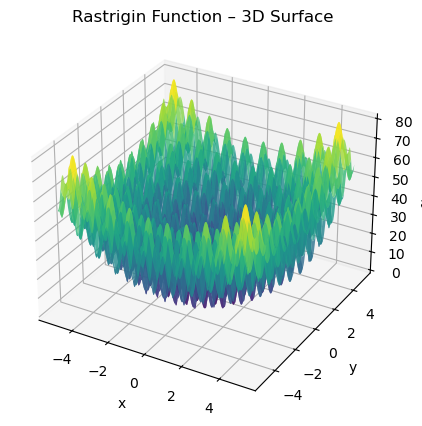

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define Rastrigin function
def rastrigin(x, y):
    return 20 + x**2 + y**2 - 10 * (np.cos(2 * np.pi * x) + np.cos(2 * np.pi * y))

# Create a grid over [-5.12, 5.12] × [-5.12, 5.12]
x_r = np.linspace(-5.12, 5.12, 400)
y_r = np.linspace(-5.12, 5.12, 400)
X_r, Y_r = np.meshgrid(x_r, y_r)
Z_r = rastrigin(X_r, Y_r)

# 1.1 2D Contour Plot
plt.figure(figsize=(6, 5))
cp = plt.contourf(X_r, Y_r, Z_r, levels=50, cmap='viridis')
plt.title("Rastrigin Function – Contour")
plt.xlabel("x")
plt.ylabel("y")
plt.colorbar(cp)
plt.show()

# 1.2 3D Surface Plot
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X_r, Y_r, Z_r, cmap='viridis', edgecolor='none', alpha=0.8)
ax.set_title("Rastrigin Function – 3D Surface")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("f(x, y)")
plt.show()

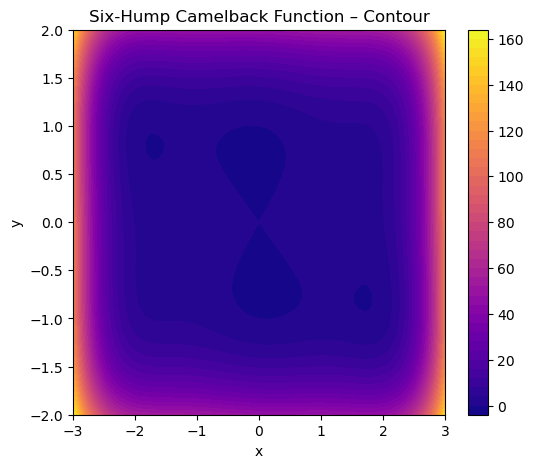

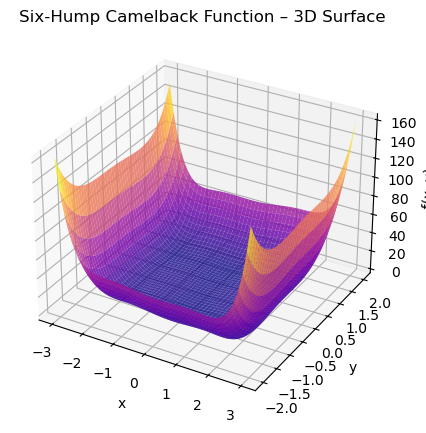

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define Six-Hump Camelback function
def six_hump_camelback(x, y):
    return (4 - 2.1 * x**2 + (x**4) / 3) * x**2 + x * y + (-4 + 4 * y**2) * y**2

# Create a grid over [-3, 3] × [-2, 2]
x_s = np.linspace(-3, 3, 400)
y_s = np.linspace(-2, 2, 400)
X_s, Y_s = np.meshgrid(x_s, y_s)
Z_s = six_hump_camelback(X_s, Y_s)

# 2.1 2D Contour Plot
plt.figure(figsize=(6, 5))
cp = plt.contourf(X_s, Y_s, Z_s, levels=50, cmap='plasma')
plt.title("Six-Hump Camelback Function – Contour")
plt.xlabel("x")
plt.ylabel("y")
plt.colorbar(cp)
plt.show()

# 2.2 3D Surface Plot
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X_s, Y_s, Z_s, cmap='plasma', edgecolor='none', alpha=0.8)
ax.set_title("Six-Hump Camelback Function – 3D Surface")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("f(x, y)")
plt.show()